# **AI Final Presentation**
**Smishing Text Message Classifier Using BERT Model**


* 14146301 Kim dong min
* 15146301 Kang shin hyeok
* 15146317 Lee seung jun

# Good motivation for the project and an explanation of the problem statement



The so called 'spam texting' and 'spam e-mails' are all increasing day by day. Korea Communications Commission and the Korea Internet & Security Agency (KISA) releases report about the "Spam Distribution Status" every twice a year. It examines the current status of spam-related situations such as the amount of mobile phone and email spam, the amount of reception and the blocking rate of spam prevention services. According to the results of a survey on the distribution of spam in first half of the year 2019, text messaging for mobile phones increased by 960,000 (17%).

Average daily spam message per person was 0.53 case, while voice spam (0.06→0.07 cases) and text messaging (0.03→0.07 cases) increased compared to the second half of last year. In addition, it is becoming difficult to block spam as it bypasses the filtering technique of telecommunication companies and KISA blocking system through a method of using a different numbers and different spam content. Currently, more than 80 percent of all spam is through mass text messaging services.

Therefore, government is planning to set up a system to effectively prevent spam-based crimes by sharing spam data with related regulators. Also by upgrading big data analysis, detection, and blockage systems, the government is trying to increase the rate of spam prevention.

Like stated, spam is a severe problem for not only personal but for the whole country as well. So, we chose this project of detecting spam messages to reduce the damages of innocent people. The problem is to divide a given messages whether it is spam or not.

# A description of the data

**Data description**

- Normal and smishing text messages provided by KB Financial Group and KISA (Korea Internet & Security Agency) 

- Target value: Probability of the smishing variable for each id by utilizing the corresponding features 

  * SPECIFICATION: For the protection of personal information, the names, phone numbers, bank names, and branch names that can be considered personal information have been filtered to X or *.

 
\


* **Data set we have**  
   * train.csv(295945 rows)
   * public_test.csv(8105 rows)
* **Data partitioning**
   * training 80%
   * validation 20%





In [0]:
!pip install mxnet
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master
!pip install sentencepiece
!pip install gluonnlp

In [0]:
import pandas as pd
import numpy as np
from mxnet.gluon import nn, rnn
from mxnet import gluon, autograd
import gluonnlp as nlp
from mxnet import nd 
import mxnet as mx
import time
import itertools
import random

from kobert.mxnet_kobert import get_mxnet_kobert_model
from kobert.utils import get_tokenizer
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/My Drive/Bert

test=pd.read_csv(r'train.csv',encoding='utf-8')
train=pd.read_csv(r'train.csv',encoding='utf-8')
train=train[['text','smishing']]
n_of_train=int(len(train)*0.8)
n_of_valid=int(len(train)-n_of_train)
print('number of training set = ', n_of_train)
print('number of validation set = ', n_of_valid)
train1=train[:n_of_train]
valid1=train[n_of_train:]
train2=np.asarray( train1)
valid2=np.asarray(valid1)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Bert
number of training set =  236756
number of validation set =  59189


In [0]:
print(train[:30])

                                                 text  smishing
0                            XXX은행성산XXX팀장입니다.행복한주말되세요         0
1               오늘도많이웃으시는하루시작하세요XXX은행 진월동VIP라운지 XXX올림         0
2   안녕하십니까 고객님. XXX은행입니다.금일 납부하셔야 할 금액은 153600원 입니...         0
3   XXX 고객님안녕하세요XXX은행 XXX지점입니다지난 한 해 동안 저희 XXX지점에 ...         0
4            1월은 새로움이 가득XXX입니다.올 한해 더 많이행복한 한해되시길바랍니다         0
5                         행복한주말보내세요XXX용현남전담직원대리 XXX올림         0
6   XXX 고객님 안녕하세요XXX은행 무교지점 XXX과장입니다 오늘 아침에 눈을 뜨니 ...         0
7   XXX 고객님지난 한해 베풀어 주신 은혜 진심으로 감사 드립니다.가슴 깊이 간직 하...         0
8          설연휴 가족들과 훈훈한 정 나누시고 정겨운추억 많이 만드세요XXX오XXX올림         0
9   (광고)XXXBaXXX고객님들 뒤엔XXX 언제나 XXX새로운 마음가짐으로 새롭게 준...         1
10  사장님 안녕하십니까?XXX은행 영도지점장 입니다.항상 XXX은행 영도지점을 아끼고 ...         0
11  첫날은 아니지만 누군가 행복을 빌어주면 한달내내 행복하다는  문자를 받았어요. 1월...         0
12         이번에 인사이동으로 유통단지지점으로 이동하게 되었습니다. 건강하십시요.XXX         0
13       고객님의 귀중한 자산 맡겨주셔서감사합니다.활기찬 하루 보내세요.XXX옥천 XXX         0
14  XXX 고객님항상 저희 XXX은행 미XXX점에 베풀어 주시는 성원

In [0]:
bert_base, vocab = get_mxnet_kobert_model(use_decoder=False, use_classifier=False)

using cached model
using cached model


In [0]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


In [0]:
class BERTDataset(mx.gluon.data.Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        sent_dataset = gluon.data.SimpleDataset([[
            i[sent_idx],
        ] for i in dataset])
        self.sentences = sent_dataset.transform(transform)
        self.labels = gluon.data.SimpleDataset(
            [np.array(np.float32(i[label_idx])) for i in dataset])

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))
    
max_len=128

data_train=BERTDataset(train2, 0,1,tok,max_len,True,False)
data_valid=BERTDataset(valid2, 0,1,tok,max_len,True,False)    
batch_size=32
lr=5e-5
train_dataloader = mx.gluon.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = mx.gluon.data.DataLoader(data_valid, batch_size=batch_size, num_workers=5)

  
**Explanation of Variables**

    id

The unique number that each text message has.

(id of train data and public_test data are not duplicated)

    year_month

The year and month the customer received the text message

    text

Content of Customer Transmitted Text

    smishing

(train_data only) Indicates whether the text is smishing or not\
(0 - Not Smishing, 1 - Smishing)

\
* **Data set we need to make**  
 submission.csv


**Explanation of Variables**

    id

The unique number that each text message has.

    smishing

We need to write the predicted probability of smishing per id

# What is BERT?

We used a language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models, BERT is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.

BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement).


* Size of two BERT models
>![대체 텍스트](https://miro.medium.com/max/2363/1*IAR9iWB0HWYwH9PVTpDvfQ.png)

 * We choosed BERT-Base,since we have limitation of computing resources and time.



**Main Features of Model**

\
* Bidirectional Model
>![대체 텍스트](https://miro.medium.com/max/2289/1*ARMfhOTPxDWDiiAb-jFrvw.png)

 * Figure 1 illustrates the pre-training model architecture used by BERT, OpenAI GPT, and ELMo, respectively.
   * Whereas OpenAI GPT uses left-to-right transformers, 
   * ELMo uses independent left-to-right, right-to-left models, 
   * BERT uses a single **bi-directive model to view both contexts simultaneously**.

* Masked LM
>![대체 텍스트](https://miro.medium.com/max/2327/1*tYSz81sdRi5M9kM4CAAm8g.png)

 * If only the deep lateral model described above is used, the cycle can be created inside the model and the training itself can become meaningless.
 * In general, if the number of hidden layers in the Neural Network increases by more than the number of input parameters, the learned result is likely to equal the input value. 
 * To prevent this, BERT developers came up with a technique called Masked LM. 
It randomly select a word from the input word array and use it.
   * replacing it with [MASK] with 80% chance, 
   * replacing it with random words with 10% chance, 
   * replacing it with the remaining 10% probability.


* Next Sentence Prediction
>![대체 텍스트](https://miro.medium.com/max/2333/1*vqjsioHNWqvfAZlxaiMr3A.png)

 * Since many of the tasks used in the performance evaluation require understanding the relationship of sentences, BERT developers are also learning from BERT to predict the relevance of sentences. 
 * Sentences were extracted from the monolingual compass, and sentences pairs were labelled
   * If they were actually linked -> **labelled as  IsNext**
   * Randomly selected sentences -> **labelled as NotNext**

# Any hyperparameter and architecture choices that were explored







* Types of models we select

  * Multilingual_bert110 
   * multilingual model trained with 1.1 million words

  * KoBert 
   * Model trained with 900,000 words designed in SKT


* Cutting sentences using the Bert-tokenizer provided by Gluon-NLP

* Using Fine Tuning, attach the classification model under the existing trained BERT model.

* Vectorized data and label data types are unified into float32.

* The final result value is set to class number 1 to output one result.


* Hyperparameter setting

 * dropout = 0.1 (To prevent overfitting)
 * batch =32 (Over batch_size shows low memory error)
 * max_len =128
 * Initial lr = 0.00005
 * loss_function = sigmoid binary Cross entropyLoss Function
 * gradient = bertadam
 * Final classification model's activation function = linear

* Use 0.1 amount of data for warm up
   * warm up?
    * If the data set is very imbalanced, over-compliance problems may occur depending on the initial learning rate. If the mixed data include features that have a significant impact on a cluster, the initial training of the model may attempt the wrong training depending on features that are not relevant to the classification model at all. Warm-up is a way to reduce the impact of early education. Without this, additional model learning may be necessary because the model is likely to initially have a large orientation in the wrong direction.

* To run the model, the server added p2.xlarge instance to AWS DeepLearning Ubuntu 16.04 AMI was acquired and used.


# Experiment#1:  **KoBERT VS Multilingual BERT**

In [0]:
#compare the tokenizer
#multilingual BERT
bert_base, vocab = nlp.model.get_model('bert_12_768_12',
                                             dataset_name='wiki_multilingual_cased',
                                             pretrained=True, use_pooler=True,
                                             use_decoder=False, use_classifier=False)


tok = nlp.data.BERTTokenizer(vocab, lower=False)
ds = gluon.data.SimpleDataset([['안녕 나는 이승준 입니다.','사랑해요 나도 울고있어요 오 난']])
trans = nlp.data.BERTSentenceTransform(tok, max_seq_length=20)
a=list(ds.transform(trans))
print(a[0])

(array([     2,   9521, 118741, 100585,   9638,  48210,  54867,   9645,
        48345,    119,      3,   9405,  62200,  14523,  48549,   8982,
        12092,   9607,  11664,      3], dtype=int32), array(20, dtype=int32), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32))


In [0]:
bert_base, vocab = get_mxnet_kobert_model(use_decoder=False, use_classifier=False)

tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)
ds = gluon.data.SimpleDataset([['안녕 나는 이승준 입니다.','사랑해요 나도 울고있어요 오 난']])
trans = nlp.data.BERTSentenceTransform(tok, max_seq_length=20)
b=list(ds.transform(trans))
print(b[0])

using cached model
using cached model
using cached model
(array([   2, 3135, 5724, 1375, 3711, 7288,  517, 7139,  517,   54,    3,
       2590, 7848, 6999, 1370, 5859, 3524, 5439, 7141,    3], dtype=int32), array(20, dtype=int32), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32))


In [0]:



class BERTClassifier(nn.Block):
    def __init__(self,
                 bert,
                 num_classes=2,
                 dropout=None,
                 prefix=None,
                 params=None):
        super(BERTClassifier, self).__init__(prefix=prefix, params=params)
        self.bert = bert
        with self.name_scope():
            self.classifier = nn.HybridSequential(prefix=prefix)
            if dropout:
                self.classifier.add(nn.Dropout(rate=dropout))

            self.classifier.add(nn.Dense(units=num_classes))

    def forward(self, inputs, token_types, valid_length=None):
        _, pooler = self.bert(inputs, token_types, valid_length)
        return self.classifier(pooler)


model=BERTClassifier(bert_base, num_classes=1, dropout=0.1)

loss_function=gluon.loss.SigmoidBCELoss()
metric=mx.metric.Accuracy()

model.classifier.initialize(init=mx.init.Normal(0.02))

model.hybridize()
print(model.summary)

trainer = gluon.Trainer(model.collect_params(), 'bertadam',
                        {'learning_rate': lr, 'epsilon': 1e-9, 'wd':0.01})

log_interval = 4
num_epochs = 3

for _, v in model.collect_params('.*beta|.*gamma|.*bias').items():
    v.wd_mult = 0.0
params = [
    p for p in model.collect_params().values() if p.grad_req != 'null'
]



using cached model
using cached model
<bound method Block.summary of BERTClassifier(
  (bert): BERTModel(
    (encoder): BERTEncoder(
      (dropout_layer): Dropout(p = 0.1, axes=())
      (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
      (transformer_cells): HybridSequential(
        (0): BERTEncoderCell(
          (dropout_layer): Dropout(p = 0.1, axes=())
          (attention_cell): MultiHeadAttentionCell(
            (_base_cell): DotProductAttentionCell(
              (_dropout_layer): Dropout(p = 0.1, axes=())
            )
            (proj_query): Dense(768 -> 768, linear)
            (proj_key): Dense(768 -> 768, linear)
            (proj_value): Dense(768 -> 768, linear)
          )
          (proj): Dense(768 -> 768, linear)
          (ffn): BERTPositionwiseFFN(
            (ffn_1): Dense(768 -> 3072, linear)
            (activation): GELU()
            (ffn_2): Dense(3072 -> 768, linear)
            (dropout_layer): Dropout(p = 

In [0]:

def evaluate_accuracy(model, data_iter, ctx=ctx):
    acc = mx.metric.Accuracy()
    i = 0
    for i, (t,v,s, label) in enumerate(data_iter):
        token_ids = t.as_in_context(ctx)
        valid_length = v.as_in_context(ctx)
        segment_ids = s.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = model(token_ids, segment_ids, valid_length.astype('float32'))
        acc.update(preds=output, labels=label)
        if i > 1000:
            break
        i += 1
    return(acc.get()[1])


step_size = batch_size
num_train_examples = len(data_train)
num_train_steps = int(num_train_examples / step_size * num_epochs)
warmup_ratio = 0.1
num_warmup_steps = int(num_train_steps * warmup_ratio)
step_num = 0

for epoch_id in range(num_epochs):
    metric.reset()
    step_loss = 0
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(train_dataloader):
        if step_num < num_warmup_steps:
            new_lr = lr * step_num / num_warmup_steps
        else:
            non_warmup_steps = step_num - num_warmup_steps
            offset = non_warmup_steps / (num_train_steps - num_warmup_steps)
            new_lr = lr - offset * lr
        trainer.set_learning_rate(new_lr)
        with mx.autograd.record():
            # load data to GPU
            token_ids = token_ids.as_in_context(ctx)
            valid_length = valid_length.as_in_context(ctx)
            segment_ids = segment_ids.as_in_context(ctx)
            label = label.as_in_context(ctx)

            # forward computation
            out = model(token_ids, segment_ids, valid_length.astype('float32'))
            ls = loss_function(out, label).mean()

        # backward computation
        ls.backward()

          trainer.allreduce_grads()
          nlp.utils.clip_grad_global_norm(params, 1)
          trainer.update(token_ids[1])
          step_num += 1
          
        step_loss += ls.asscalar()
        metric.update([label], [out])
        if (batch_id + 1) % (50) == 0:
            print('[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.10f}, acc={:.3f}'
                         .format(epoch_id + 1, batch_id + 1, len(train_dataloader),
                                 step_loss / log_interval,
                                 trainer.learning_rate, metric.get()[1]))
            step_loss = 0
    test_acc = evaluate_accuracy(model, test_dataloader, ctx)
    model.save_parameters('model_ko_preprocessing.'+str(epoch_id)+'.params') 

    print('Test Acc : {}'.format(test_acc))

In [0]:
#predict accuracy, f1_score

output=pd.read_csv(r'valid(binary3_epoch2).csv', encoding='utf-8')

output=output[['0','1']]
output=output.rename(columns={'0':'y_pred'})
output=output.rename(columns={'1':'y_true'})

y_pred=[]
y_true=[]
for i in range(len(output['y_pred'])):
    
    a=output['y_pred'][i]
    a=a.replace('\n','')
    a=a.replace('[','')
    a=a.split(']')
    a.pop()
    a.pop()

    for j in a:
        if float(j)>0:
            s=1
        else:
            s=0
        y_pred.append(s)
    
    
    b=output['y_true'][i]
    b=b.replace('\n','')
    b=b.replace('[','')
    b=b.split(']')
    b=b[0]
    b=b.split(' ')    
    b=b[0:32]
    for k in b:
        y_true.append((np.float32(k)))
        

y_pred=pd.DataFrame(y_pred)
y_true=pd.DataFrame(y_true)
from sklearn.metrics import accuracy_score,f1_score
acc=accuracy_score(y_true=y_true, y_pred=y_pred)
f1=f1_score(y_true, y_pred)

print('accuracy = ', acc , 'f1 score = ', f1)

accuracy =  0.9994762540336887 f1 score =  0.9980570354120966


We used same code as KoBERT but used different model with Multilingual BERT by Google.

 * The result of Multilingual BERT model.
  * Between y_true and zero

>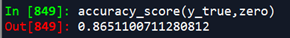

We got an outcome accuracy of Multilingual BERT model. ‘y_true’ is for the original label we used and ‘zero’ is information with all 0 value. Therefore, this showed us with how much zeros were inside the model. It showed that it contains 86 percent of zero and 14 percent of one.

  * Between y_true and y_pred

>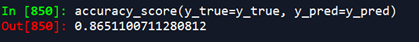

Then, we did evaluation with original label and predicted label. However, it came out with an answer that it had same probability with comparing between zero. This meant that our prediction model could not correctly define one. By looking at the actual model, we got a result of all zero.

* Conclusion

The result of Multilingual BERT came out with 0 percent of correctly defining 1. We thought that by analyzing KoBERT model and Multilingual BERT, it was said that it has different pretrained values putted inside. KoBERT was known to have different tokenization method, which would improve the performance of Korean.

To prove our idea, we looked more closely at the difference between tokenization and vectorization of words in two different models. We came with result that it really did have difference while tokenizing words and then vectorizing those words. By comparing the same sentence, we found that KoBERT model gathered the features more correctly.



Therefore, we used KoBERT model and tried to evaluate further.



# Experiment#2:  **KoBERT VS KoBERT with Pre-processed data set**


In [0]:

import re 
#preprocessing


def name(text):
    pattern=r'XXX'
    new_text=re.sub(pattern, '이름', text)
    return new_text
    
def price(text):
    re_pattern = r'\d{1,3}[,\.]\d{1,3}[만\천]?\s?[원]|\d{1,5}[만\천]?\s?[원]'
    text = text.replace(re_pattern, 'money')
    re_pattern = r'[일/이/삼/사/오/육/칠/팔/구/십/백][만\천]\s?[원]'
    new_text = text.replace(re_pattern, '돈')
    return new_text

def date(text):
    re_pattern = r'(?!-)\d{2,4}[0]{2,4}(?!년)(?!.)|\d{1,4}[,/.]\d{2}[,/.]\d{2}'
    new_text = text.replace(re_pattern, '날짜')
    return new_text

def korean(text):
    re_pattern = re.compile('[^ A-Z a-z ㄱ-ㅎ ㅏ-ㅣ 가-힣 ]+')
    new_text=re.sub(re_pattern, ' ', text)
    return new_text


def preprocessing(file):
    prepro=[]
    for i in range(len(file['text'])):
        j=file['text'][i]
        j=name(j)
        j=price(j)
        j=date(j)
        j=korean(j)
        line=[j, file['smishing'][i]]
        prepro.append(line)
    a=pd.DataFrame(prepro)
    a=a.rename(columns={0:'text'})
    a=a.rename(columns={1:'smishing'})
    return a

train_preprocessing=preprocessing(train)

In [0]:
train_preprocessing[:30]

,text,smishing
0,이름은행성산이름팀장입니다 행복한주말되세요,0
1,오늘도많이웃으시는하루시작하세요이름은행 진월동VIP라운지 이름올림,0
2,안녕하십니까 고객님 이름은행입니다 금일 납부하셔야 할 금액은 원 입니다 감사합니...,0
3,이름 고객님안녕하세요이름은행 이름지점입니다지난 한 해 동안 저희 이름지점에 보내주신...,0
4,월은 새로움이 가득이름입니다 올 한해 더 많이행복한 한해되시길바랍니다,0
5,행복한주말보내세요이름용현남전담직원대리 이름올림,0
6,이름 고객님 안녕하세요이름은행 무교지점 이름과장입니다 오늘 아침에 눈을 뜨니 눈이 ...,0
7,이름 고객님지난 한해 베풀어 주신 은혜 진심으로 감사 드립니다 가슴 깊이 간직 하겠...,0
8,설연휴 가족들과 훈훈한 정 나누시고 정겨운추억 많이 만드세요이름오이름올림,0
9,광고 이름Ba이름고객님들 뒤엔이름 언제나 이름새로운 마음가짐으로 새롭게 준비합니다...,1




We conducted the first experiment. We trained KoBERT with both the original data and the pre-processed data, and compared the results.

* **Result of KoBERT Model with Raw Dataset**
 * Epoch 1 val_accuracy
>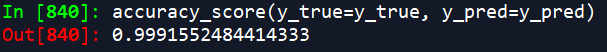

 * Epoch 2 val_accuracy
>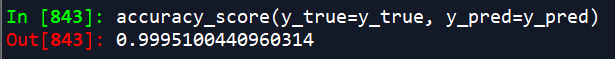

 * Epoch 3 val_accuracy
 >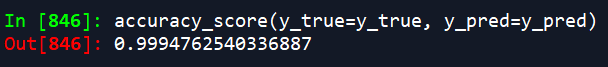


* Since the Epoch 2 val_accuracy is higher than Epoch 3 val_accuracy, we assumed that Epoch 3 has been overfitted. 


* F-1 score of Epoch 2
>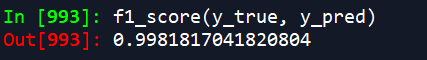



* **Result of KoBERT Model with Pre-Processed Dataset**
 * Epoch 1 val_accuracy
> 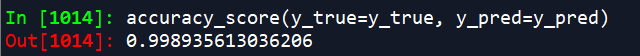

 * Epoch 2 val_accuracy
>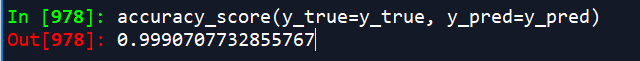

 * Epoch 3 val_accuracy
>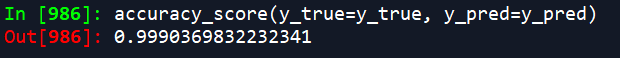

* Since the Epoch 2 val_accuracy is higher than Epoch 3 val_accuracy, we assumed that Epoch 3 has been overfitted. 

* F-1 score of Epoch 2
>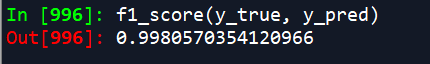

* Conclusion
 * Pre-processing results showed no significant difference compared to the model created using the original data. 
   * Pre-treatment process needs to be supplemented during further research.

 * Since Epoch 2 has the best results in common, it is considered the best result to the extent that this model is not overfitted.

# Any insights and discussions relevant to the project


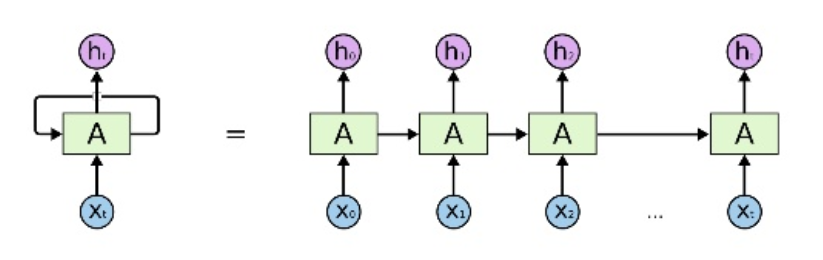

Traditional neural networks are difficult to process in a continuous sequence. For example, fields such as natural language processing, voice recognition, stocks, weather, and music, where the order of input is important required new models. The natural language processing that we needed for the project was also a sequence, which required a different model. So we started looking for different models. 

The first is the RNN structure. The RNN architecture is the architecture which affects the current result with previous values. There are two weights: circular W and input U. This allows for various forms of input and output. However, this has the disadvantage of information disappearance as the first input information goes backward.

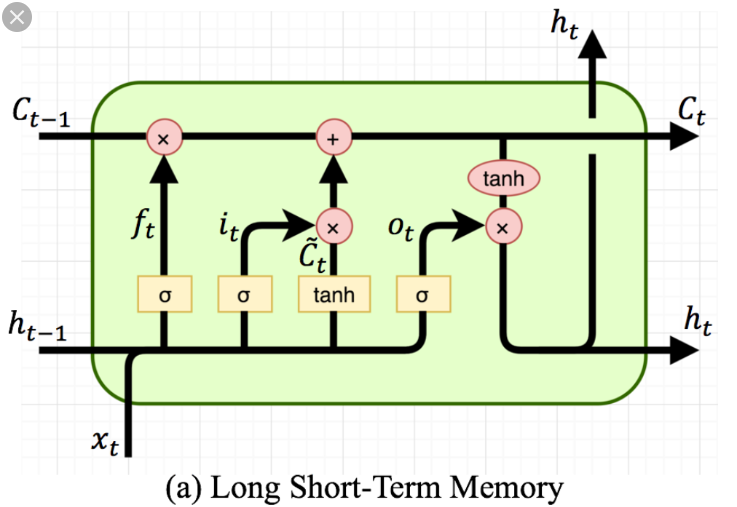

The manipulated structure is LSTM, which delivers key information in the input to back without forgetting it. A total of eight weights, four each for input and cycle, are divided into input, output, and delete gates.

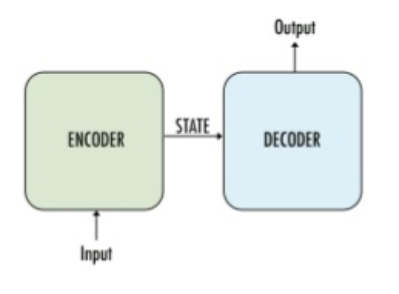

The Seq2Seq model consists of two LSTM which is encoder and decoder. This prevents the disadvantage of RNN, less accurate because the output is only considered up to the previous input, and not reflecting the entire input sentence. Input sentences are processed with encoder first and answer sentences are printed with decoder. However, the Seq2Seq model also had the disadvantage of being limited to only gate (delete, input, output gate) that adjusts the flow of information, and that longer text results in less accurate answers.

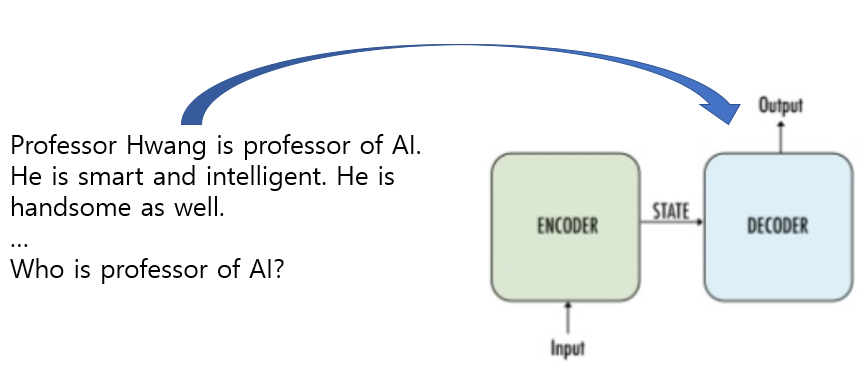

The Encoder-Decoder structure is  the process of dividing sentence into words by tokenization and using embedding technology (Word2Vecm GloVe) to vectorize the words. Then, it uses RNN like LSTM as an input to gain intermediate result (Encoder) and final result using output (Decoder). Using this kind of processing structure for natural language processing, we have discovered a number of problems. We didn't just choose the word that we used earlier, or by the sentence criteria. For example, in English, you may first choose a verb to use for a later noun. To solve this, the first solution that came out was using a bi-directional RNN structure, and the model has evolved in that way.

Attention focuses on important word (attention) to deliver right away to decoder. The Attention Seq2Seq model is an advanced model that aggregates the output values of the encoder and is used together for decoder calculations (in the form of an attention + Seq2Seq).


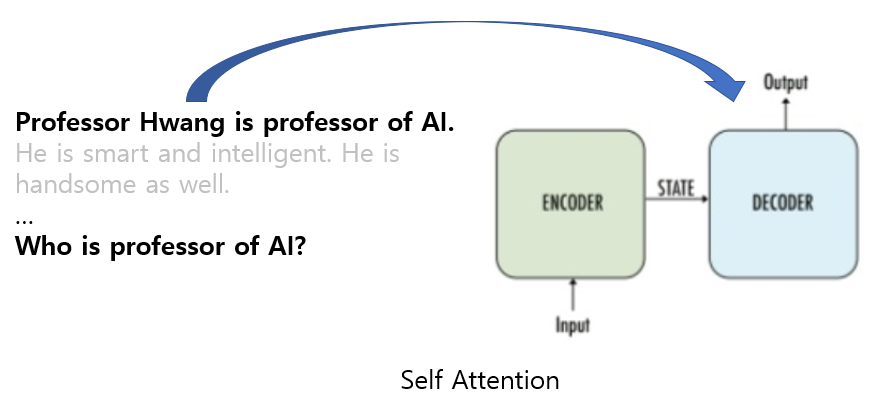

Transformer, a model released by Google in 2017, implemented encoders and decoders using only an attention neural network without the need of LSTM. Instead of using encoder and a decoder, it performs self-attention operations in the sentence to convert each word to Q K V to calculate the attention. It focuses on the important words in the sentence and update the information for each word. There are several encoders and decoder overlays in the Transformers. 
Elmo and Bert which came out later used a pre-trained language model, which helped offset the disadvantage of embedded vectors, like Word2Vec and GloVe, which does not reflect context. It is a contextualized word embedding, which reflects context by considering the entire sentence before embedding a word.



BERT outperformed other models in GLUE (General Language Understanding Evaluation) Benchmark, which ranks models based on the performance of 11 NLP Tasksneral Language Understanding Evaluation) Benchmark. This is also the latest deep learning language model which came to attention after breaking the best performance of previous records of SQUAD(Stanford Question Answering Dataset) benchmark.

 * Conclusion

Just like the summary of each model, we compared and studied many models from the beginning to the latest in the natural language processing model. We looked at a lot of papers and information, and we concluded that models like Word2Vec and GloVe are low in performance compared to ELMO and BERT, which usage was meaningless to get the best results. Also, in case of ELMO model, it was difficult to use because there were no models that were pre-trained in Korean. However, there were some models for the BERT that were pre-trained in Korean. KoBERT, a BERT model pre-trained in Korean provided by SKT, is pretrained through corpus with millions of Korean sentences collected from Wikipedia or New. Then it applied data-based tokenization techniques to improve performance. Google also provided a Multilingual BERT model that can be used in a variety of languages. Therefore, we came out with conclusion to focus on using BERT model for comparing and analyzing natural language.





 * Before preprocessing

>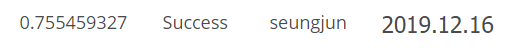


* After preprocessing

>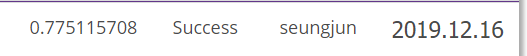

The score of the model by using the test data from the contest we participated got the result like above. By doing preprocessing, we were able to increase the score. However, we thought that the score was not that high as we expected. By analyzing more, we looked at the actual result of the model.

 * Imbalance of data

>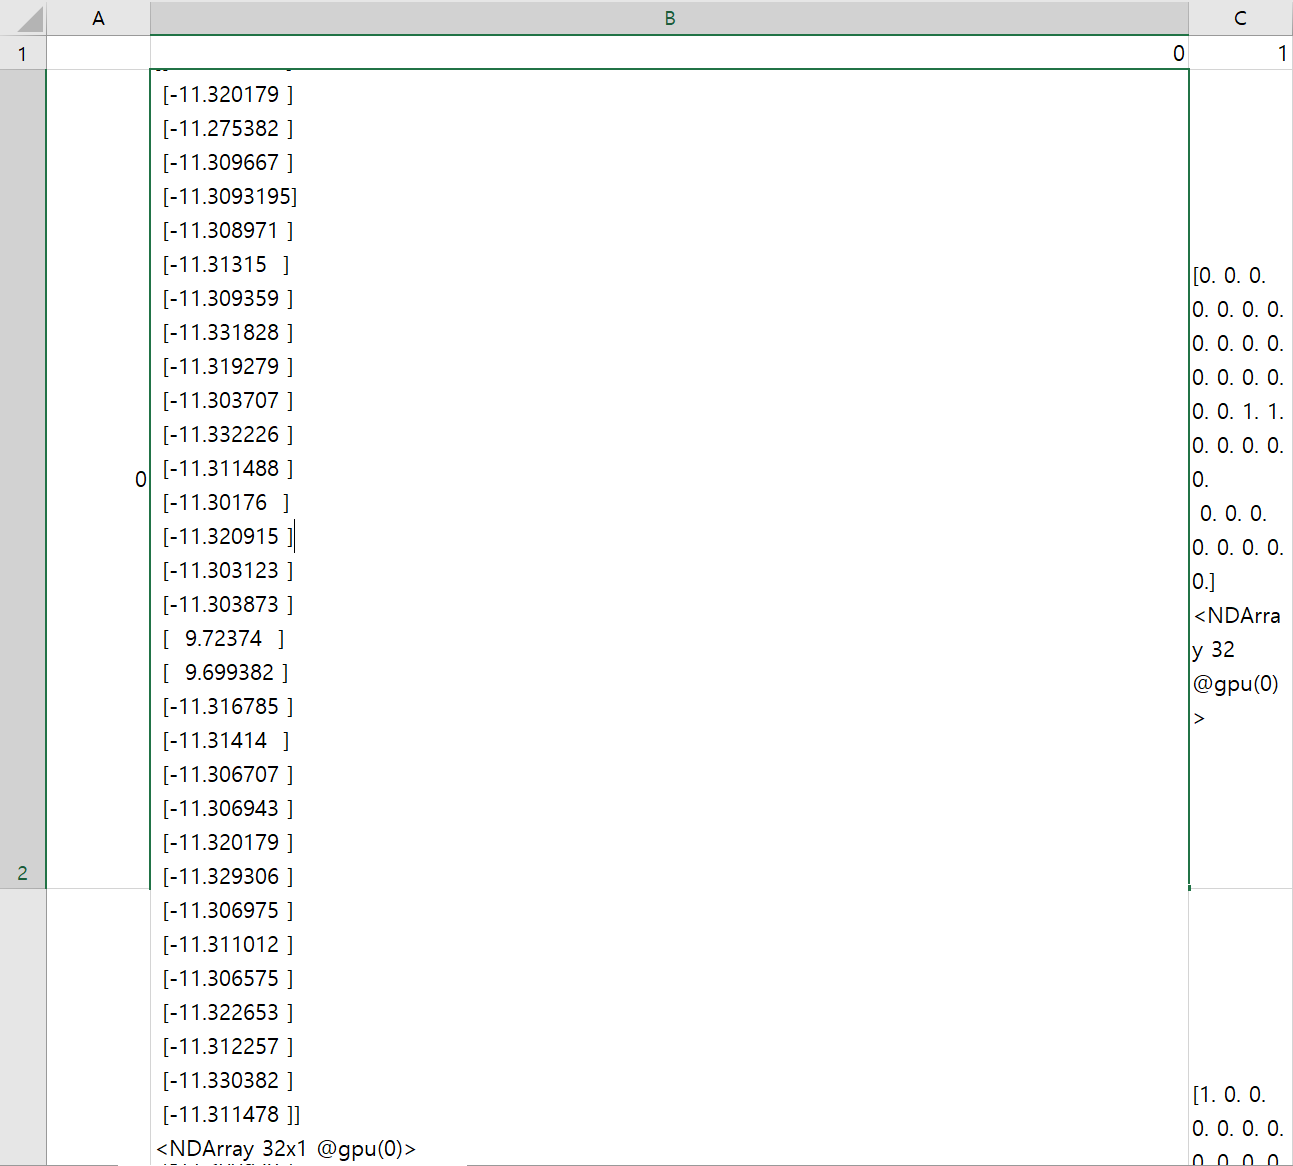

By analyzing the actual model, we found that the model was imbalanced. So we came out with conclusion that our not that high result was probably due to imbalace of data.

We got an insight that further on, we will try to reduce the imbalance by under fitting the model.

# (Extra credit) References




* KoBERT model designed by SKTBrain

  * Link to official github: https://github.com/SKTBrain/KoBERT

* multilingual BERT model made by Google

  * Link to official github: https://github.com/google-research/bert

* NLP by Deep Learning ( What is Natural Language Process
  * Link to official Book : https://wikidocs.net/44249 

* Introduce Pre-Train BERT
  * Link to journal : http://freesearch.pe.kr/archives/4963

* Introduce Gluon NLP
  * Link to official Site : https://gluon-nlp.mxnet.io/

* Introduce MXNET
  * Link to official Site : https://beta.mxnet.io/#

* Utilize MXNET
  * Link to official Site : https://mxnet.apache.org/

* Introduce SentencePieces
  * Link to gitbut : https://github.com/google/sentencepiece

* Analysis of Dropout
  * Link to official Site : https://ko.d2l.ai/chapter_deep-learning-basics/dropout.html

* Introduce Sklearn
  * Link to official Site : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score

* Generate Model on AWS
  * Link to official Site AWS : https://aws.amazon.com/ko/

# (Extra credit) Member's constribution statement




* Dongmin - 3
* Shinhyeok - 3
* Seungjun -4

# (Extra credit) Debugging experience worth sharing


1. Using BERT Model which has large Memory allocation

* minimum environment to run the model = 
memory 24G + titan RTX or 32G + tesla V100

* High memory allocation of BERT model did not work in local or colab and out of memory error --> Train and evaluate models after setting up the environment using AWS server.

* Using Instance --> Deep Learning Ubuntu 16.04 version AMI + Instance p2.xlarge (GPU tesla v100*4)

2. Environment-compatible

* Install Anaconda on Server for Virtual Environment Use
* Installation of necessary libraries for learning models and setting environment variables
* MXNet
* Google Sentencepiece
* Gluon NLP
* KOBERT
* so on...

3. memory error on linux server

* Check the model memory quota with df -h and perform the removal of certain folders and files that are using large memory.
* ubuntu@ip-172-31-45-39:~$ for dir in *; do [ -d "$dir" ] && echo "$dir" && find "$dir" | wc -l; done : check the current directory memory
* Rm -rf filename : remove the file 

In [0]:

class BERTClassifier(nn.Block):
    def __init__(self,
                 bert,
                 num_classes=2,
                 dropout=None,
                 prefix=None,
                 params=None):
        super(BERTClassifier, self).__init__(prefix=prefix, params=params)
        self.bert = bert
        with self.name_scope():
            self.classifier = nn.HybridSequential(prefix=prefix)
            if dropout:
                self.classifier.add(nn.Dropout(rate=dropout))

            self.classifier.add(nn.Dense(units=num_classes))

    def forward(self, inputs, token_types, valid_length=None):
        _, pooler = self.bert(inputs, token_types, valid_length)
        return self.classifier(pooler)


model=BERTClassifier(bert_base, num_classes=1, dropout=0.1)

loss_function=gluon.loss.SigmoidBCELoss()
metric=mx.metric.Accuracy()

model.classifier.initialize(init=mx.init.Normal(0.02))

model.hybridize()
print(model.summary)